In [1]:
# Version requirements: Python 3.14.2, numpy 2.3.5, matplotlib 3.10.8, pywt 1.8.0, scipy 1.16.3
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [ ]:
def wavelet_denoise(signal, wavelet_name = 'db4', level=5, threshold=0.2):
    coeffs = pywt.wavedec(signal, wavelet_name, level=level)
    coeffs_thresholded = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet_name)
    return denoised_signal


In [ ]:
def dwt_denoise_global(signal, wavelet='haar', level=2, keep_fraction=0.1):
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    
    n_keep_total = max(1, int(np.round(len(coeff_arr) * keep_fraction)))
    
    idx = np.argpartition(np.abs(coeff_arr), -n_keep_total)
    compressed_arr = np.zeros_like(coeff_arr)
    compressed_arr[idx[-n_keep_total:]] = coeff_arr[idx[-n_keep_total:]] # Keeping largest coefficients
    
    final_coeffs = pywt.array_to_coeffs(compressed_arr, coeff_slices, output_format='wavedec')
    
    total_kept = n_keep_total

    reconstructed = pywt.waverec(final_coeffs, wavelet)[:len(signal)]
    mse = np.mean((signal - reconstructed)**2)
    compression_ratio = 1 - (total_kept / len(signal))

    return reconstructed, compression_ratio, mse, total_kept

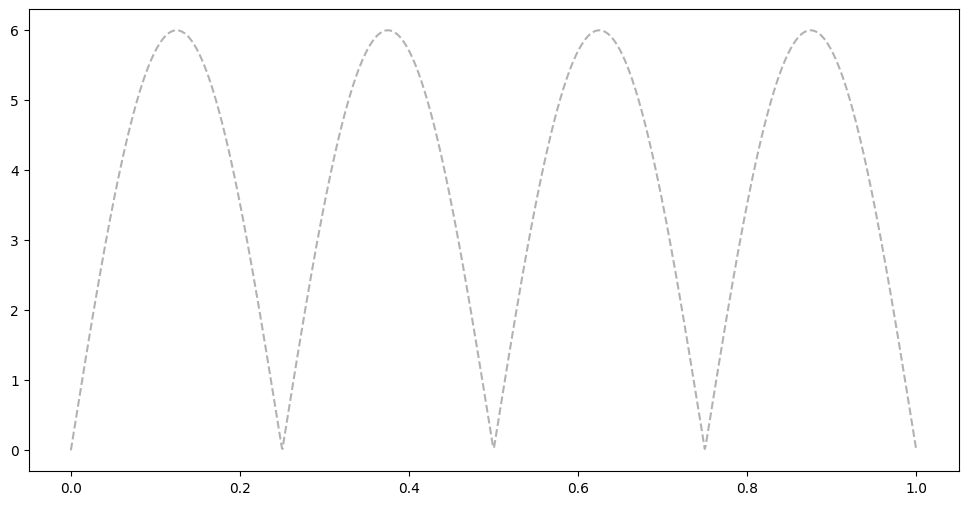

In [ ]:
N = 1024
t = np.linspace(0, 1, N)
signal = 6 * np.abs(np.sin(2 * np.pi * 2 * t)) 
noisy_signal = signal + np.random.normal(0, 1.0, size=signal.shape)
plt.figure(figsize=(12, 6))
plt.plot(t, signal, color='black', linestyle='--', alpha=0.3, label='Original')

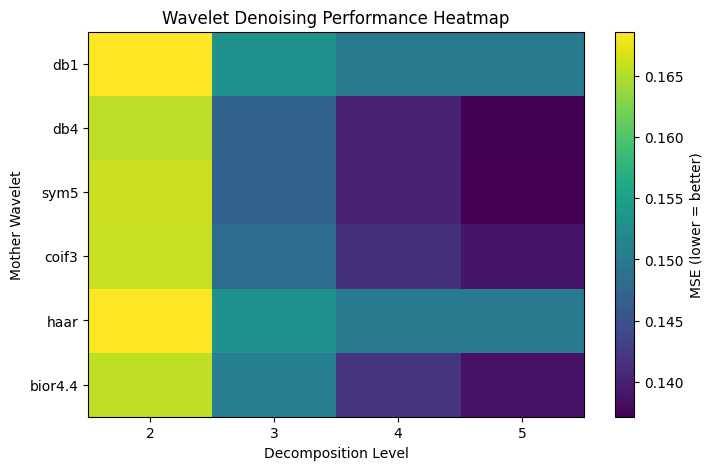

In [ ]:
wavelets = ['db1','db4', 'sym5', 'coif3', 'haar', 'bior4.4']
levels = [2, 3, 4, 5]

noisy_signal = signal + 0.5 * np.random.normal(size=signal.shape)
heatmap = np.zeros((len(wavelets), len(levels)))

for i, w in enumerate(wavelets):
    for j, l in enumerate(levels):
        denoised = wavelet_denoise(noisy_signal, wavelet_name=w, level=l, threshold=0.2)
        mse = np.mean((signal - denoised)**2)
        heatmap[i, j] = mse

plt.figure(figsize=(8,5))
im = plt.imshow(heatmap, aspect='auto', cmap='viridis')
plt.colorbar(im, label='MSE (lower = better)')
plt.xticks(ticks=np.arange(len(levels)), labels=levels)
plt.yticks(ticks=np.arange(len(wavelets)), labels=wavelets)
plt.xlabel("Decomposition Level")
plt.ylabel("Mother Wavelet")
plt.title("Wavelet Denoising Performance Heatmap")
plt.show()

c:\Users\User\Desktop\WaveLets\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


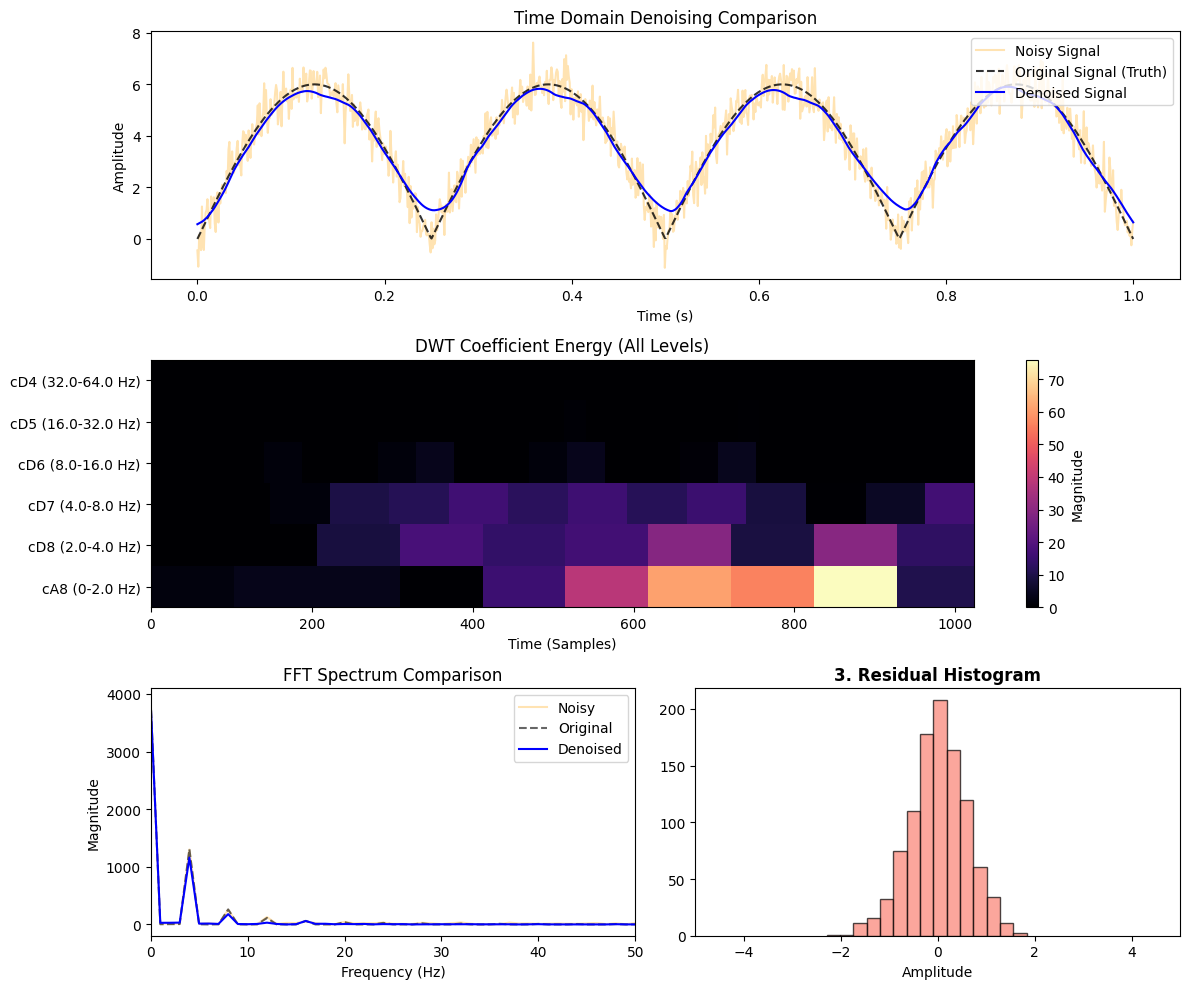

In [ ]:

N = 1024   
fs = 1024
time = np.linspace(0, 1, N)
wavelet = 'db4'
level = 8

coeffs = pywt.wavedec(noisy_signal, wavelet, level=level)
sigma = np.median(np.abs(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(N))

denoised_coeffs = [coeffs[0]] 
for i in range(1, len(coeffs)):
    denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='soft'))

denoised_signal = pywt.waverec(denoised_coeffs, wavelet)[:N]


heatmap_list = []
y_labels = []

for i in range(6):
    data = np.abs(denoised_coeffs[i])
    repeat_factor = int(np.ceil(N / len(data)))
    heatmap_list.append(np.repeat(data, repeat_factor)[:N])
    
    if i == 0:
        f_low, f_high = 0, fs / 2**(level + 1)
        y_labels.append(f"cA{level} (0-{f_high:.1f} Hz)")
    else:
        current_level = level - i + 1
        f_low = fs / 2**(current_level + 1)
        f_high = fs / 2**(current_level)
        y_labels.append(f"cD{current_level} ({f_low:.1f}-{f_high:.1f} Hz)")


dwt_matrix = np.vstack(heatmap_list)

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(time, noisy_signal, color='orange', alpha=0.3, label='Noisy Signal')
ax1.plot(time, signal, 'k--', alpha=0.8, label='Original Signal (Truth)')
ax1.plot(time, denoised_signal, color='blue', linewidth=1.5, label='Denoised Signal')
ax1.set_title("Time Domain Denoising Comparison")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend(loc='upper right')


ax2 = fig.add_subplot(gs[1, :])

im = ax2.imshow(dwt_matrix, aspect='auto', cmap='magma', origin='lower', interpolation='nearest')
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_yticklabels(y_labels)

ax2.set_ylim(-0.5, len(y_labels) - 0.5) 
ax2.set_title("DWT Coefficient Energy (All Levels)")
ax2.set_xlabel("Time (Samples)")
fig.colorbar(im, ax=ax2, label="Magnitude")

ax3 = fig.add_subplot(gs[2, 0])
xf = np.fft.rfftfreq(N, 1/fs)
yf_orig = np.abs(np.fft.rfft(signal))
yf_noisy = np.abs(np.fft.rfft(noisy_signal))
yf_denoised = np.abs(np.fft.rfft(denoised_signal))

ax3.plot(xf, yf_noisy, color='orange', alpha=0.3, label='Noisy')
ax3.plot(xf, yf_orig, 'k--', alpha=0.6, label='Original')
ax3.plot(xf, yf_denoised, color='blue', label='Denoised')
ax3.set_xlim(0, 50) 
ax3.set_title("FFT Spectrum Comparison")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Magnitude")
ax3.legend()

ax4 = fig.add_subplot(gs[2, 1])
ax4.hist(noisy_signal - denoised_signal, bins=15, color='salmon', edgecolor='black', alpha=0.7)
ax4.set_xlim(-5,5)
ax4.set_title("3. Residual Histogram", fontweight='bold')
ax4.set_xlabel("Amplitude")

plt.tight_layout()
plt.show()

Instead of utilizing thresholds to set coefficients to 0, we will in this part set coefficients to 0 based on their magnitude and deciding a percentage to keep. This is done for illustrating purposes.

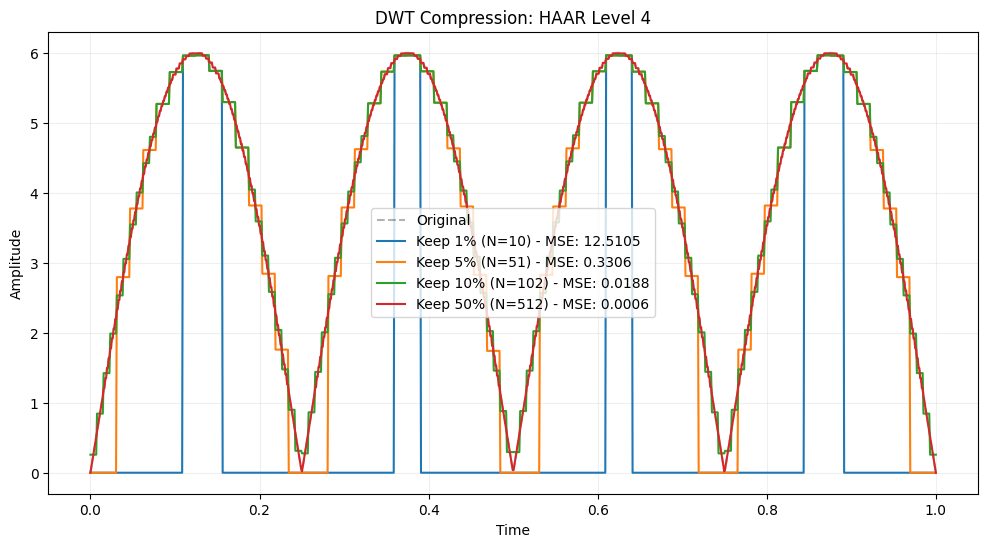

In [ ]:

fractions = [0.01, 0.05, 0.1, 0.5] 
wavelet = 'haar'
level = 4 

plt.figure(figsize=(12, 6))
plt.plot(t, signal, color='black', linestyle='--', alpha=0.3, label='Original')

for f in fractions:
    comp_sig, cr, mse,_ = dwt_denoise_global(signal, wavelet=wavelet, level=level, keep_fraction=f)

    total_coeffs = N
    kept_count = int(total_coeffs * (1 - cr))
    
    plt.plot(t, comp_sig, label=f'Keep {int(f*100)}% (N={kept_count}) - MSE: {mse:.4f}')

plt.title(f"DWT Compression: {wavelet.upper()} Level {level}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

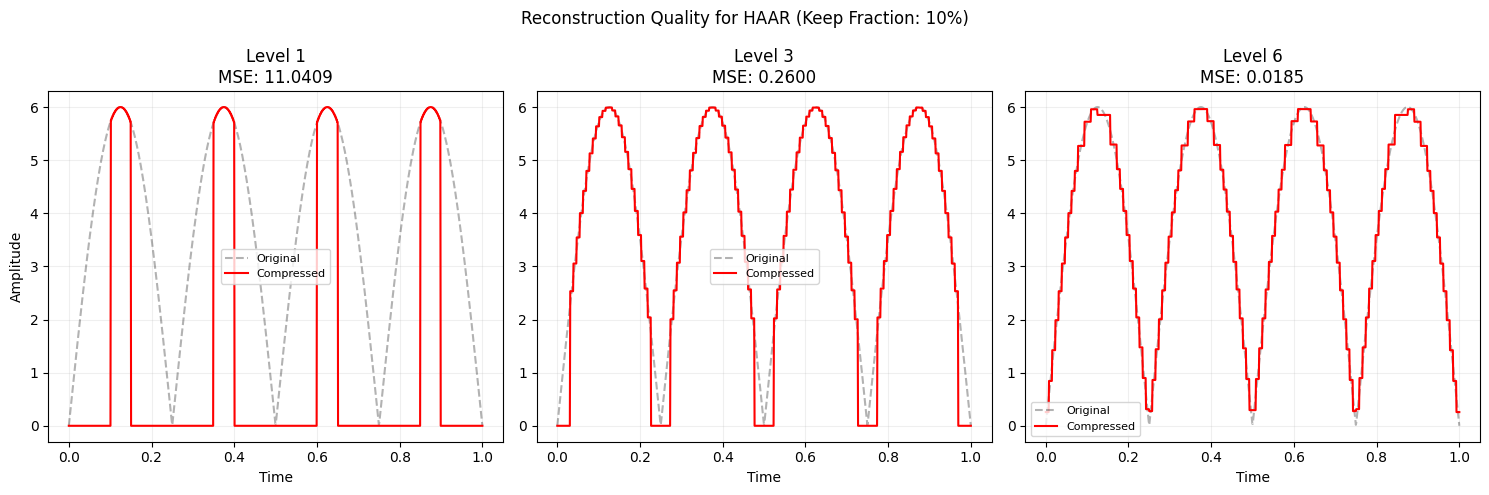

In [ ]:
def plot_reconstruction_comparison(signal, wavelet='haar', levels=[1, 3, 5], fraction=0.1):
    """
    Plots original vs reconstructed signals at different levels to visualize 
    why MSE changes.
    """
    t = np.linspace(0, 1, len(signal))
    plt.figure(figsize=(15, 5))
    
    for i, l in enumerate(levels):
        try:
            comp_sig, cr, mse, _ = dwt_denoise_global(signal, wavelet=wavelet, level=l, keep_fraction=fraction)
            
            plt.subplot(1, len(levels), i+1)
            plt.plot(t, signal, 'k--', alpha=0.3, label='Original')
            plt.plot(t, comp_sig, 'r-', linewidth=1.5, label='Compressed')
            
            plt.title(f"Level {l}\nMSE: {mse:.4f}")
            plt.xlabel("Time")
            if i == 0: plt.ylabel("Amplitude")
            plt.legend(prop={'size': 8})
            plt.grid(True, alpha=0.2)
            
        except Exception as e:
            print(f"Level {l} failed: {e}")

    plt.suptitle(f"Reconstruction Quality for {wavelet.upper()} (Keep Fraction: {int(fraction*100)}%)")
    plt.tight_layout()
    plt.show()

plot_reconstruction_comparison(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1)

# Note the peak reconstruction quality seems to decrease as a function of level, this is because higher levels are incaple of capturing high frequency details due to their coarser resolution.

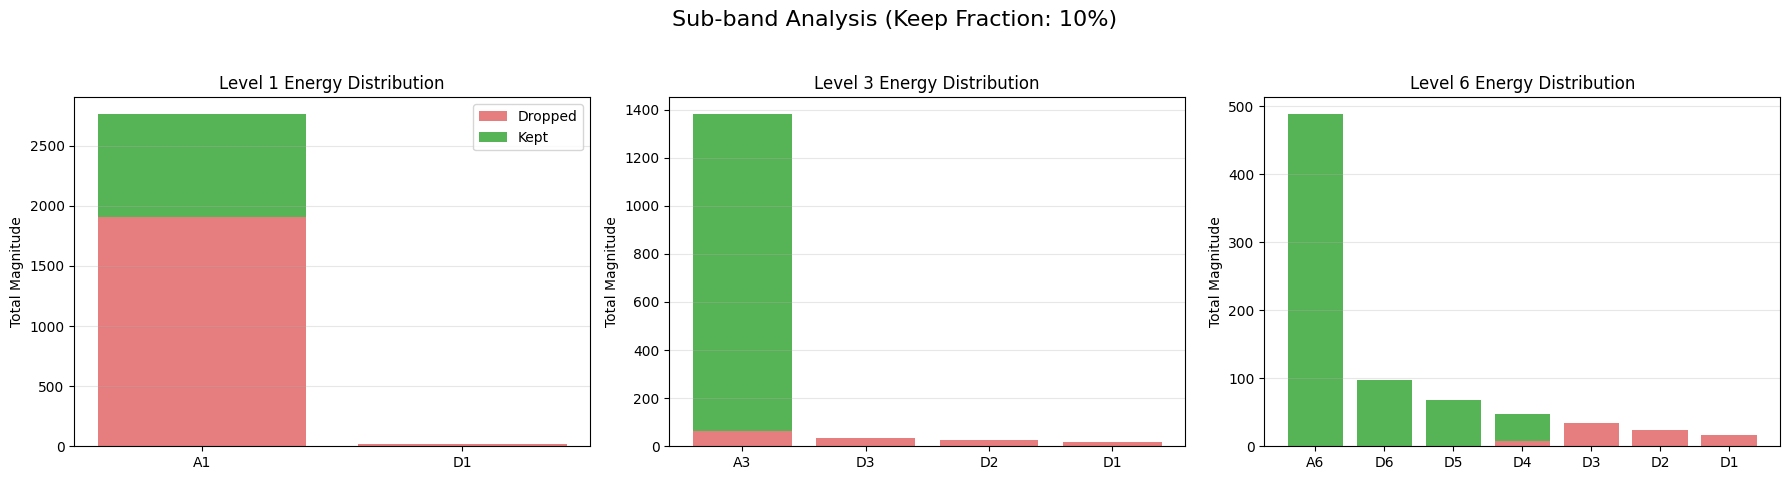

In [ ]:
def plot_subband_energy(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1):
    plt.figure(figsize=(18, 5))
    
    for i, l in enumerate(levels):
        coeffs = pywt.wavedec(signal, wavelet, level=l)
        
        all_coeffs_flat = np.concatenate([c.flatten() for c in coeffs])
        thresh_val = np.percentile(np.abs(all_coeffs_flat), (1 - fraction) * 100)
        

        labels = [f"A{l}"] + [f"D{j}" for j in range(l, 0, -1)]
        
        kept_energy = []
        dropped_energy = []
        
        for c in coeffs:

            mask = np.abs(c) >= thresh_val
            kept_energy.append(np.sum(np.abs(c[mask])))
            dropped_energy.append(np.sum(np.abs(c[~mask])))

        ax = plt.subplot(1, len(levels), i + 1)
        

        ax.bar(labels, dropped_energy, color='#d62728', alpha=0.6, label='Dropped')
        ax.bar(labels, kept_energy, bottom=dropped_energy, color='#2ca02c', alpha=0.8, label='Kept')
        
        ax.set_title(f"Level {l} Energy Distribution")
        ax.set_ylabel("Total Magnitude")
        if i == 0: ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle(f"Sub-band Analysis (Keep Fraction: {int(fraction*100)}%)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_subband_energy(signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1)

In [1]:
N = 1024
t = np.linspace(0, 1, N)

# For a 1024 Hz sine wave, D1 covers 256 - 512 Hz, D2: 128-256Hz, D3:64-128Hz, D4:32-64Hz.
# Making a 48 Hz sine wave (Targeting the D4 band: 32-64 Hz)
freq = 48 
mid_freq_signal = np.sin(2 * np.pi * freq * t) + np.random.normal(0, 0.1, N)
plt.plot(mid_freq_signal)
plot_subband_energy(mid_freq_signal, wavelet='haar', levels=[1, 3, 6], fraction=0.1)

NameError: name 'np' is not defined

The two frequency component signal. We will generate a signal with a high frequency component and a low frequency component with the intention of isolating the different components.

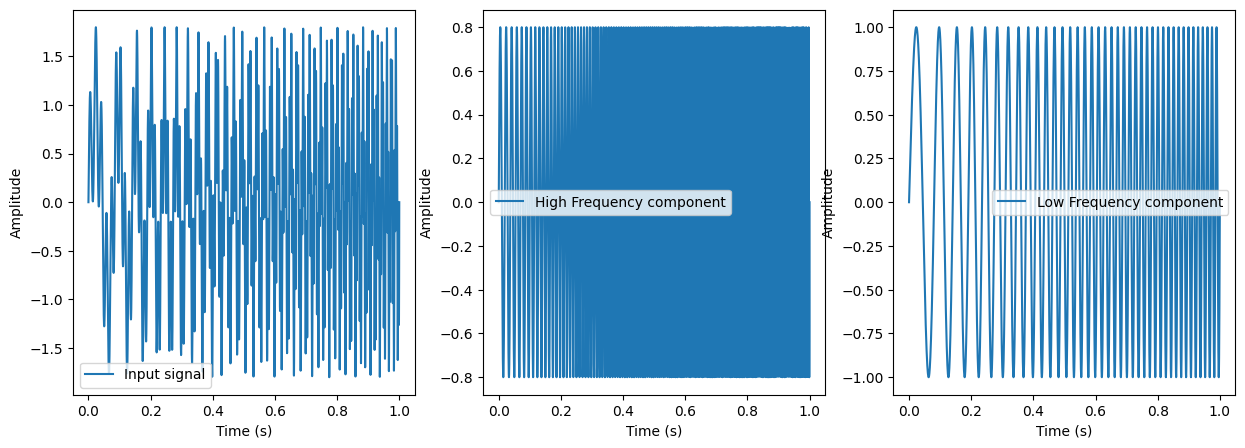

In [ ]:
fs = 8048  
time = np.linspace(0, 1, fs)

# Component 1: Low frequency (stays in the 'Approximation' / deep detail levels)
low_freq_chirp = np.sin(2 * np.pi * (10 + 30 * time) * time)

# Component 2: High frequency (stays in the 'Fine' detail levels)
high_freq_chirp = 0.8 * np.sin(2 * np.pi * (50 + 100 * time) * time)

combined_signal = low_freq_chirp + high_freq_chirp

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(time, combined_signal, label='Input signal')
axs[0].set_xlabel('Time (s)')   
axs[0].set_ylabel('Amplitude')
axs[0].legend()

axs[1].plot(time, high_freq_chirp, label='High Frequency component')
axs[1].set_xlabel('Time (s)')   
axs[1].set_ylabel('Amplitude')
axs[1].legend()

axs[2].plot(time, low_freq_chirp, label='Low Frequency component')
axs[2].set_xlabel('Time (s)')  
axs[2].set_ylabel('Amplitude')
axs[2].legend()



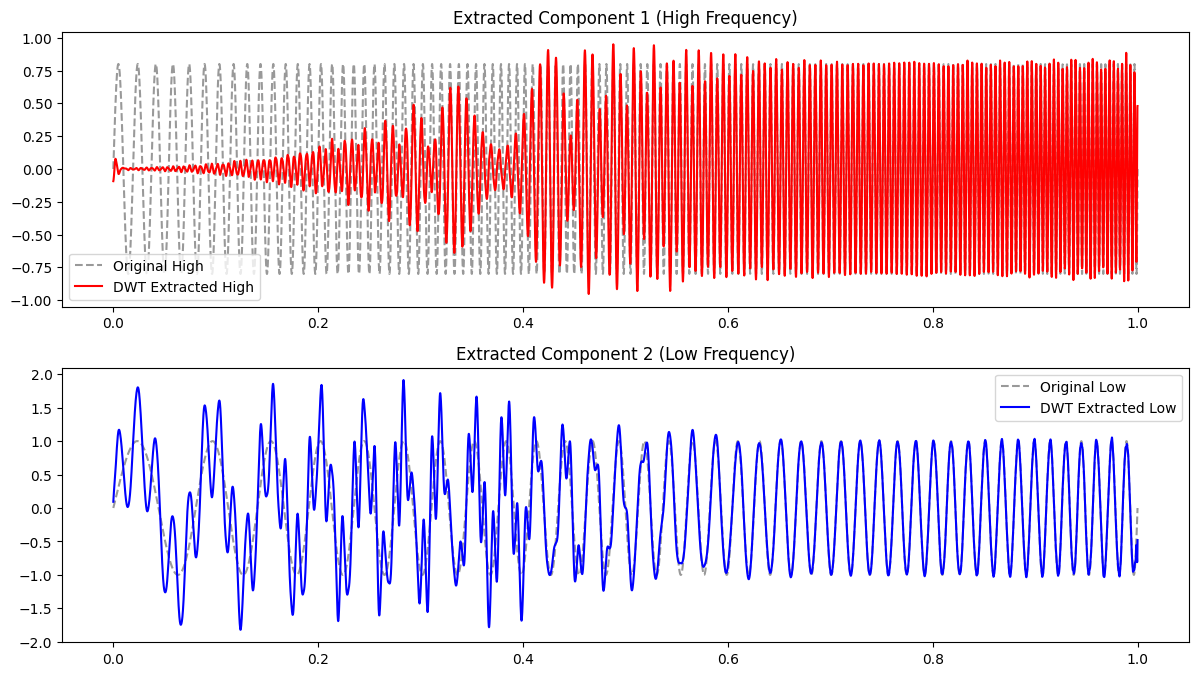

In [ ]:
wavelet = 'sym8'
level = 5
coeffs = pywt.wavedec(combined_signal, wavelet, level=level)


high_mask = [np.zeros_like(c) for c in coeffs]
high_mask[1] = coeffs[1]
high_mask[2] = coeffs[2] 
recon_high = pywt.waverec(high_mask, wavelet)[:fs]

low_mask = [np.zeros_like(c) for c in coeffs]
for i in range(3, len(coeffs)): 
    low_mask[i] = coeffs[i]
low_mask[0] = coeffs[0] 
recon_low = pywt.waverec(low_mask, wavelet)[:fs]

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 2)
plt.plot(time, high_freq_chirp, 'k--', alpha=0.4, label="Original High")
plt.plot(time, recon_high, 'r', label="DWT Extracted High")
plt.title("Extracted Component 1 (High Frequency)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, low_freq_chirp, 'k--', alpha=0.4, label="Original Low")
plt.plot(time, recon_low, 'b', label="DWT Extracted Low")
plt.title("Extracted Component 2 (Low Frequency)")
plt.legend()

plt.tight_layout()
plt.show()

Task to try, get a sound clip with multiple instruments in it. Try and seperate the different components.

Adaptive Wavelet Multiresolution for Complex PDEs. Build an adaptive wavelet solver that refine only where needed. Perhaps in fluid dynamics or combustion engines. I.e. using a high resolution grid everywhere is computaionally hard.

Implement wavelets into shock / discontinuities- capturing algorithms. Maybe utilize magnitude of wavelet coefficients as an indicator of a jump? Only apply smoothing at the jump location, preserving the sharp jump without destroying surrounding smooth flow.

Multiresolution Wavelet Tomography. Solve Ax = y. y is data and x is image. It is an ill defined problem, since you often medicine measure fewer data points than pixels in x. With wavelets solve for x and give me the sparsest wavelet representation. In the wavelet domain a lung etc should be a few large coefficients (edges, boundaries etc) and then a lot of low / 0 coeffficeints. Hopefully converge on a clear imagine (Just boundaries and edges).

Data compression on high dimension data while preserving dominant features. Perhaps in climate modelling? Preserving heavy coefficients defining storms and fronts.

Perhaps reconstruct an image utilizing only the lower levels? This might be an ML angle.
